In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


### Installing NeuralForecast (if not installed)

In [2]:
# %%capture
# !pip install neuralforecast

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [6]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

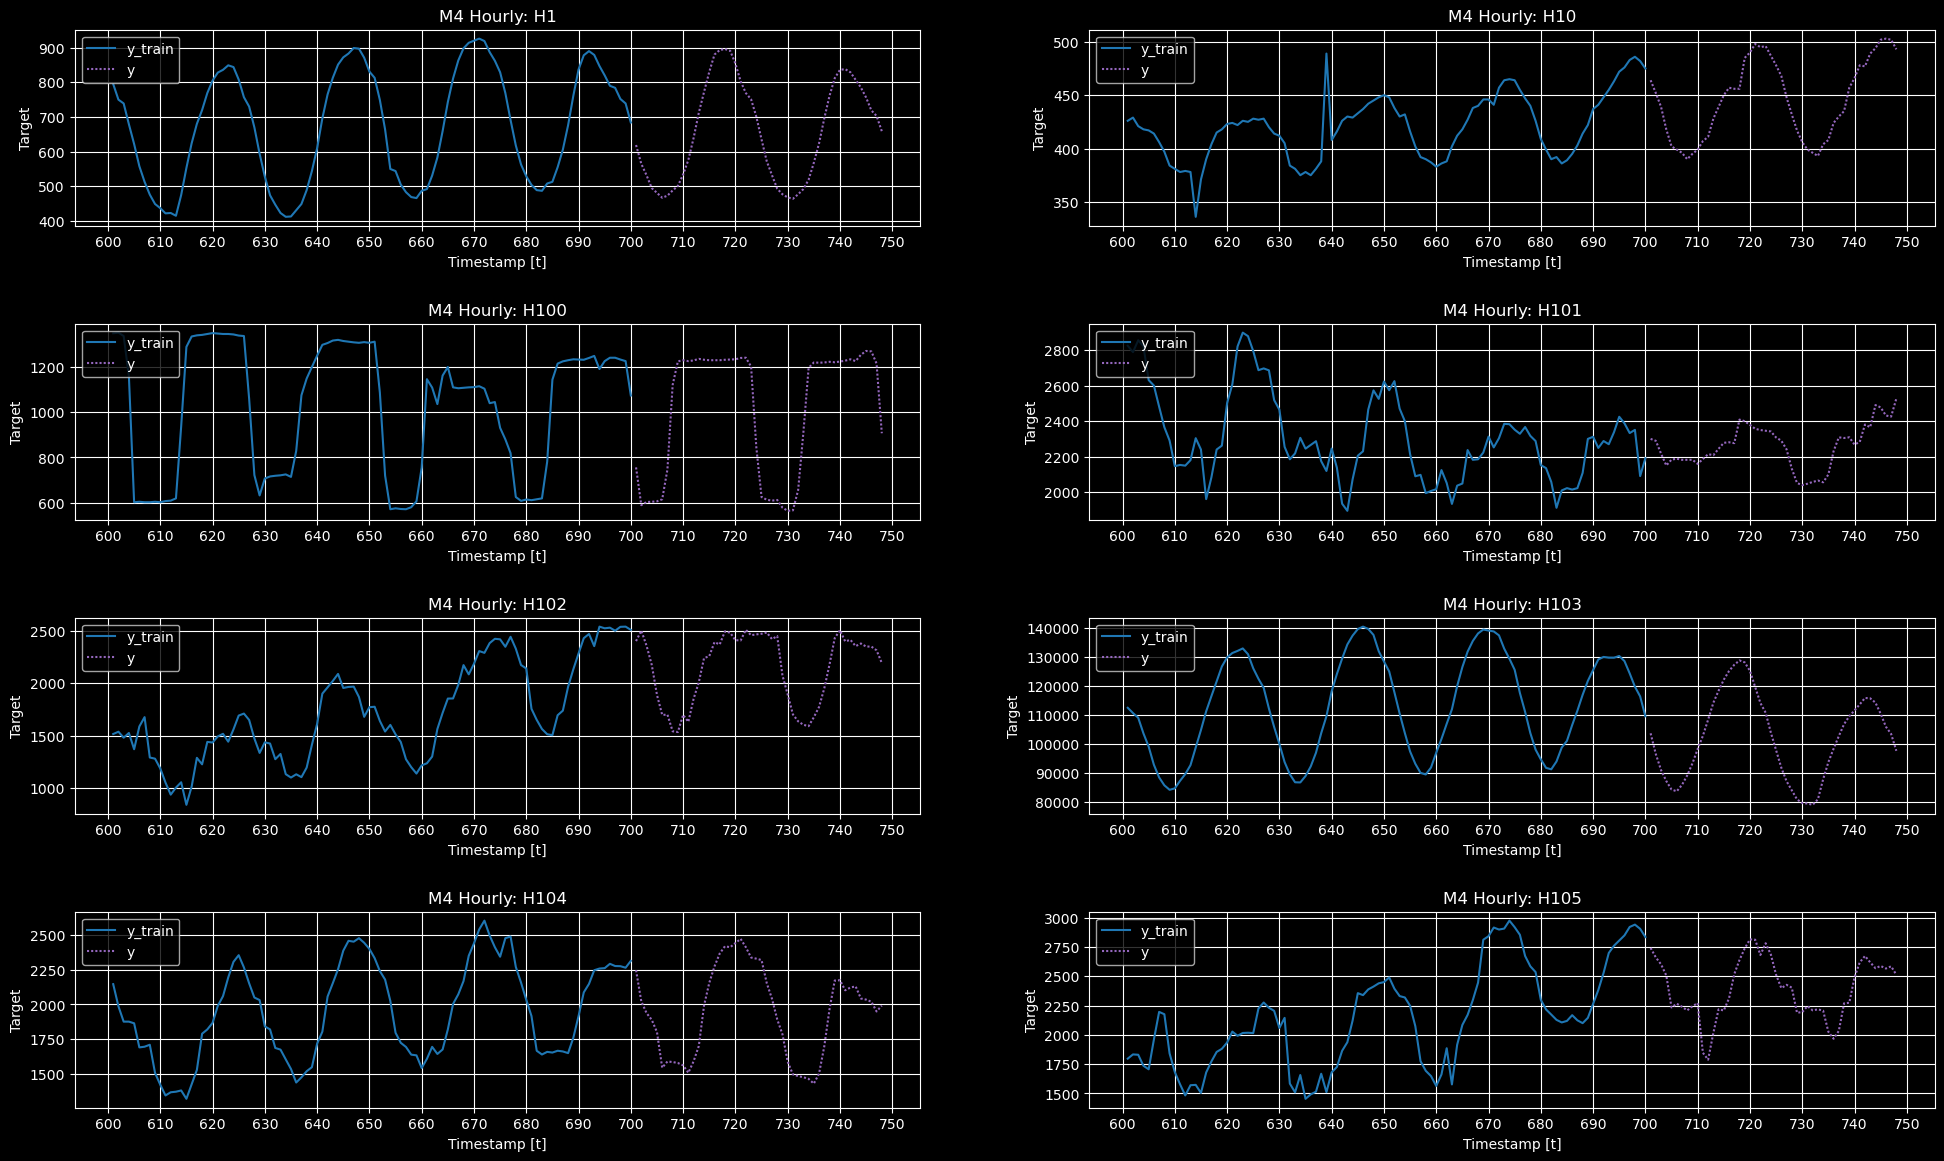

In [7]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Training

We have already seen how to use `neuralforecast` in Chapter 16. Here, lets see how we can use the same code and make it work for PDF prediction. We are going to use a simple LSTM, but the same strategy and code can be used for all the models in `neuralforecast`.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `DistributionLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals.
- `input_size` controls the size of the context window
- `encoder_hidden_size` and `decoder_hidden_size` are parameters of the LSTM. We have kept it small so that the run's are faster. These parameters should be ideally tuned and we can use `AutoLSTM` or any of the `Auto<Model>` in `neuralforecast`.

In [8]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

In [9]:
horizon = len(Y_test_df.ds.unique()) # 48
levels = [80, 90]
lstm_config = dict(
    input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
)
models = [
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="StudentT", level=levels),
        alias="LSTM_StudentT",
        **lstm_config
    ),
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="Normal", level=levels),
        alias="LSTM_Normal",
        **lstm_config
    ),
]
# Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
nf = NeuralForecast(models=models, freq=1)

Seed set to 1
Seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [10]:
%%capture
nf.fit(df=Y_train_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | DistributionLoss | 5     
1 | padder          | ConstantPad1d    | 0     
2 | scaler          | TemporalNorm     | 0     
3 | hist_encoder    | LSTM             | 928   
4 | context_adapter | Linear           | 4.3 K 
5 | mlp_decoder     | MLP              | 115   
-----------------------------------------------------
5.4 K     Trainable params
5         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
---------------------------------

In [11]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point prediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM_StudentT,LSTM_StudentT-median,LSTM_StudentT-lo-90,LSTM_StudentT-lo-80,LSTM_StudentT-hi-80,LSTM_StudentT-hi-90,LSTM_Normal,LSTM_Normal-median,LSTM_Normal-lo-90,LSTM_Normal-lo-80,LSTM_Normal-hi-80,LSTM_Normal-hi-90
0,H1,701,587.401611,587.687622,469.395142,499.491089,670.125671,698.200500,611.419006,611.872620,526.468079,544.935608,678.166870,695.755798
1,H1,702,557.220276,556.827271,443.682465,477.180328,643.317810,664.940979,572.125000,571.947266,459.525787,488.295441,660.233521,680.305420
2,H1,703,503.950500,503.530762,368.631714,400.603058,607.143066,639.557922,520.592896,520.702576,391.918121,419.979675,622.180176,650.351196
3,H1,704,456.941193,456.040131,310.875061,343.162201,565.234314,593.015015,482.831757,482.110779,342.655670,370.390991,590.644470,620.590393
4,H1,705,438.524414,438.648102,301.312164,337.204163,542.847107,578.616577,451.609039,450.634033,306.816528,340.937256,569.954102,603.503174


In [12]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

#### LSTM_StudentT

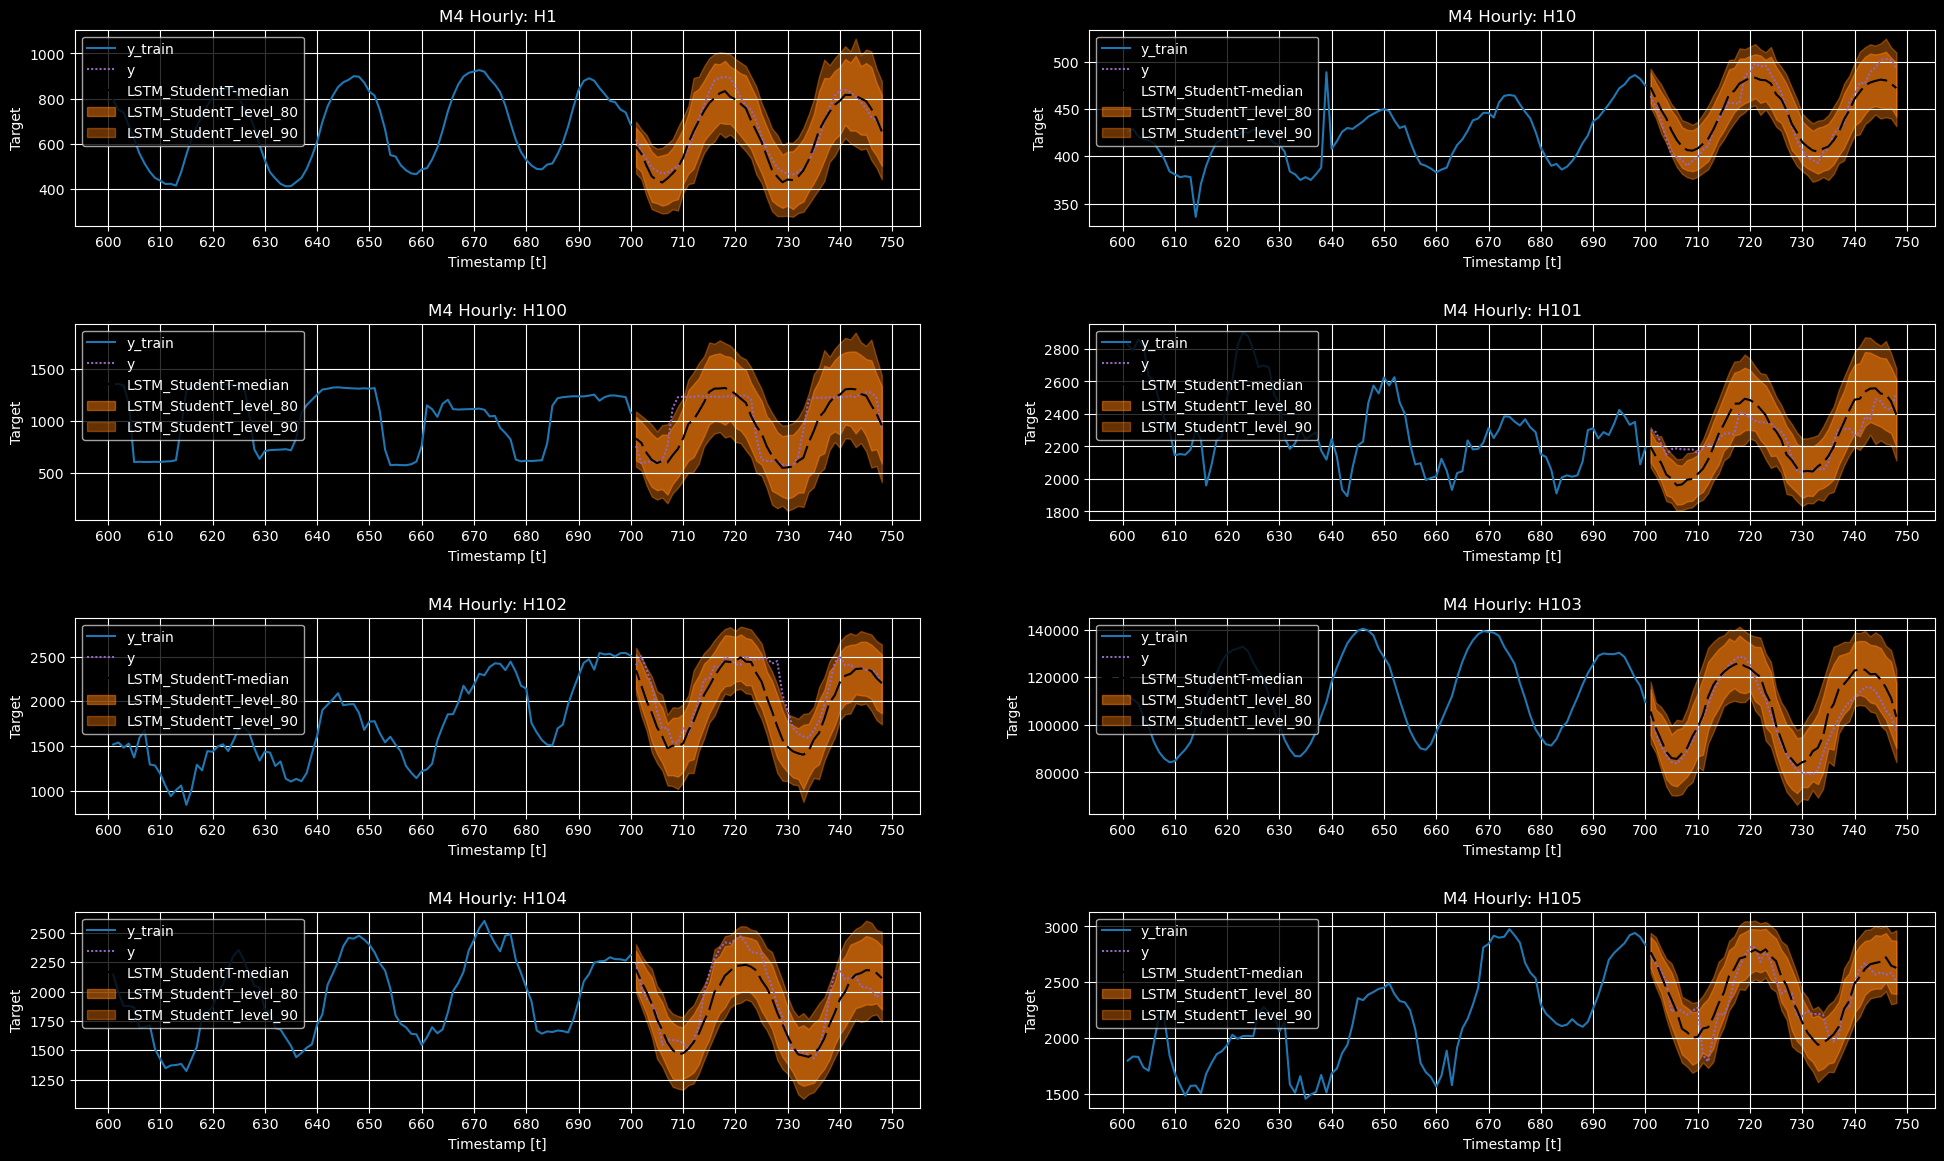

In [13]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_StudentT')

#### LSTM_Normal

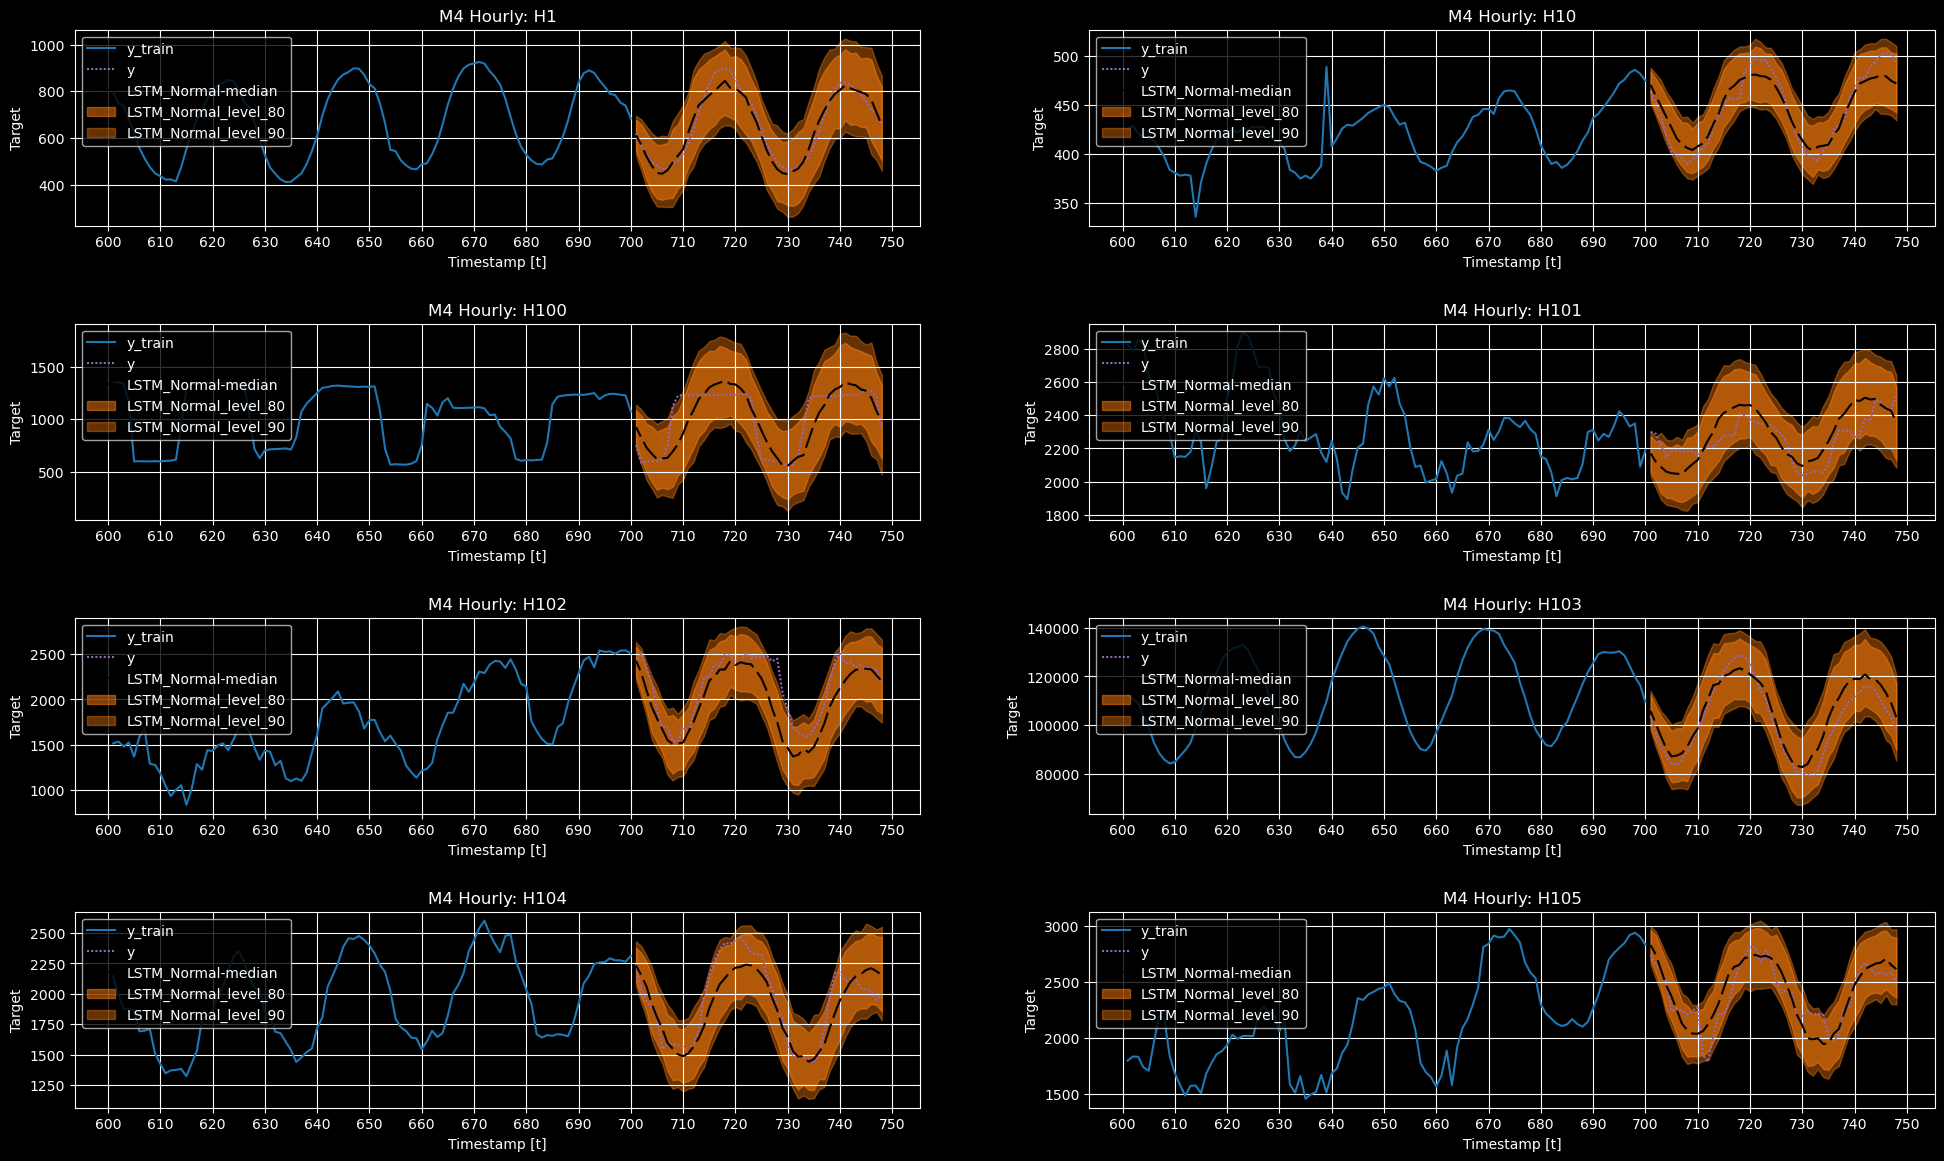

In [14]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_Normal')

#### Metrics

In [15]:
from utilsforecast.losses import mae, coverage

In [16]:
res_df = mae(Y_test_df, models=['LSTM_StudentT-median']).rename(columns={'LSTM_StudentT-median': 'LSTM_StudentT-mae'})
res_df = res_df.merge(mae(Y_test_df, models=['LSTM_Normal-median']).rename(columns={'LSTM_Normal-median': 'LSTM_Normal-mae'}), on='unique_id')
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['LSTM_Normal'], level=l).rename(columns={'LSTM_Normal': f'LSTM_Normal-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LSTM_Normal'], level=l).rename(columns={'LSTM_Normal': f'LSTM_Normal-average_length-{l}'}), on='unique_id')
    res_df = res_df.merge(coverage(Y_test_df, models=['LSTM_StudentT'], level=l).rename(columns={'LSTM_StudentT': f'LSTM_StudentT-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LSTM_StudentT'], level=l).rename(columns={'LSTM_StudentT': f'LSTM_StudentT-average_length-{l}'}), on='unique_id')
res_df

,unique_id,LSTM_StudentT-mae,LSTM_Normal-mae,LSTM_Normal-coverage-80,LSTM_Normal-average_length-80,LSTM_StudentT-coverage-80,LSTM_StudentT-average_length-80,LSTM_Normal-coverage-90,LSTM_Normal-average_length-90,LSTM_StudentT-coverage-90,LSTM_StudentT-average_length-90
0,H1,29.939713,25.848803,1.000000,282.291633,1.000000,274.193084,1.000000,362.866126,1.000000,373.996277
1,H10,10.579599,10.408894,0.979167,51.582776,0.958333,49.147437,1.000000,66.058452,1.000000,67.134174
2,H100,121.177841,123.474782,0.875000,652.541292,0.895833,641.413755,0.979167,837.615128,0.937500,878.058848
3,H101,92.412659,91.244784,0.937500,396.598897,0.770833,336.362315,0.979167,508.454315,0.875000,460.243162
4,H102,168.139506,172.745855,0.812500,626.360914,0.833333,613.164815,0.916667,805.754976,0.875000,839.652510
5,H103,4677.314779,4347.094076,1.000000,25223.671061,0.979167,24813.759277,1.000000,32350.189453,1.000000,33997.181478
6,H104,123.536072,118.758545,0.854167,512.653343,0.854167,498.459137,1.000000,655.740522,0.979167,677.973208
7,H105,108.059761,110.797223,0.854167,471.221265,0.833333,450.881271,0.958333,602.555590,1.000000,612.708539
